In [270]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import numpy as np
import open3d
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R3D

## Prepare Scene

In [272]:
from pycamcal.simulation.cornell_box import create_cornell_box
from pycamcal.simulation.checkerboard import create_checkerboard_mesh

# create basic environment for some nice visual context
cornell_box = create_cornell_box(width=6, height=5)

# create calibration target
checkerboard = create_checkerboard_mesh(num_rows=7, num_cols=10, square_size=0.25)
checkerboard.translate(-checkerboard.get_center())
checkerboard.translate([0, 1, 1])
checkerboard.rotate(R3D.from_euler("x", 90, degrees=True).as_matrix())

scene = [*cornell_box.values(), checkerboard]
print(scene)

[TriangleMesh with 8 points and 2 triangles., TriangleMesh with 8 points and 2 triangles., TriangleMesh with 8 points and 2 triangles., TriangleMesh with 8 points and 2 triangles., TriangleMesh with 8 points and 2 triangles., TriangleMesh with 280 points and 140 triangles.]


In [273]:
# # preview scene setup
# world_axes = open3d.geometry.TriangleMesh.create_coordinate_frame()
# open3d.visualization.draw_geometries([*scene, world_axes], mesh_show_back_face=True)

## Prepare Camera

In [274]:
from pycamcal.camera_model import CameraModel
from pycamcal.camera_model import RadialTangentialDistortion

distortion = RadialTangentialDistortion(
    k1=-0.25,
    k2=+0.05,
    k3=0.0,
    p1=0.0,
    p2=0.0
)

camera = CameraModel.from_fov(
    res_xy = (1200/2, 1000/2),
    fov_xy = (72, 60),
    distortion = distortion
)

print(camera)

if not distortion.is_valid_over_entire_fov(camera.get_fov(degrees=False)):
    print("WARNING: Distortion model is not valid over entire FOV! Certain regions are potentially unreachable and inversion behavior may be undefined.")

precompute_undistort_lut()
[[-1.00017716 -0.79452991]
 [-0.97981594 -0.71596195]
 [-0.95957162 -0.64006513]
 ...
 [ 0.85516795  0.55382573]
 [ 0.87270566  0.62452039]
 [ 0.89232148  0.69922826]]


<Axes: >

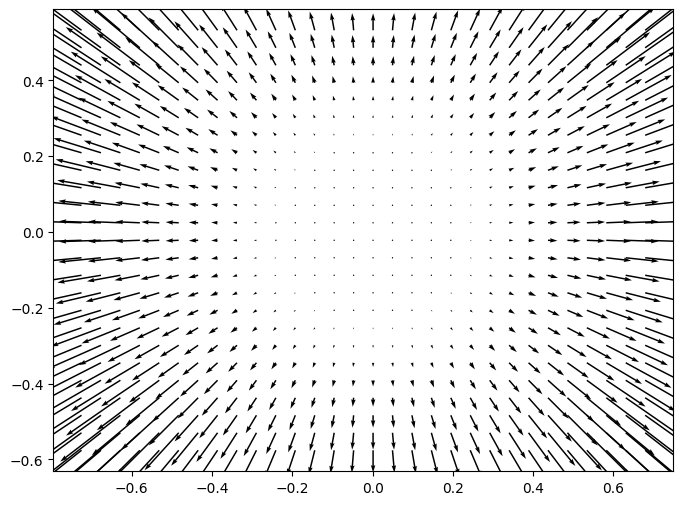

In [275]:
from pycamcal.camera_model.viz_utils import visualize_distortion_model

fig, ax = plt.subplots(figsize=(8, 6))
visualize_distortion_model(camera, subsample=20, exaggeration=1.0, ax=ax)

## Render

[[-1.00158842 -0.795784  ]
 [-1.00109196 -0.79379714]
 [-0.999263   -0.79526292]
 ...
 [ 0.999263    0.79526292]
 [ 1.00109196  0.79379714]
 [ 1.00158842  0.795784  ]]
ray_directions_sensor:
 [[-0.61684976 -0.49010068  0.61587149]
 [-0.61703012 -0.48926249  0.61635708]
 [-0.6160584  -0.49028975  0.61651278]
 ...
 [ 0.6160584   0.49028975  0.61651278]
 [ 0.61703012  0.48926249  0.61635708]
 [ 0.61684976  0.49010068  0.61587149]]
(500, 600, 3)


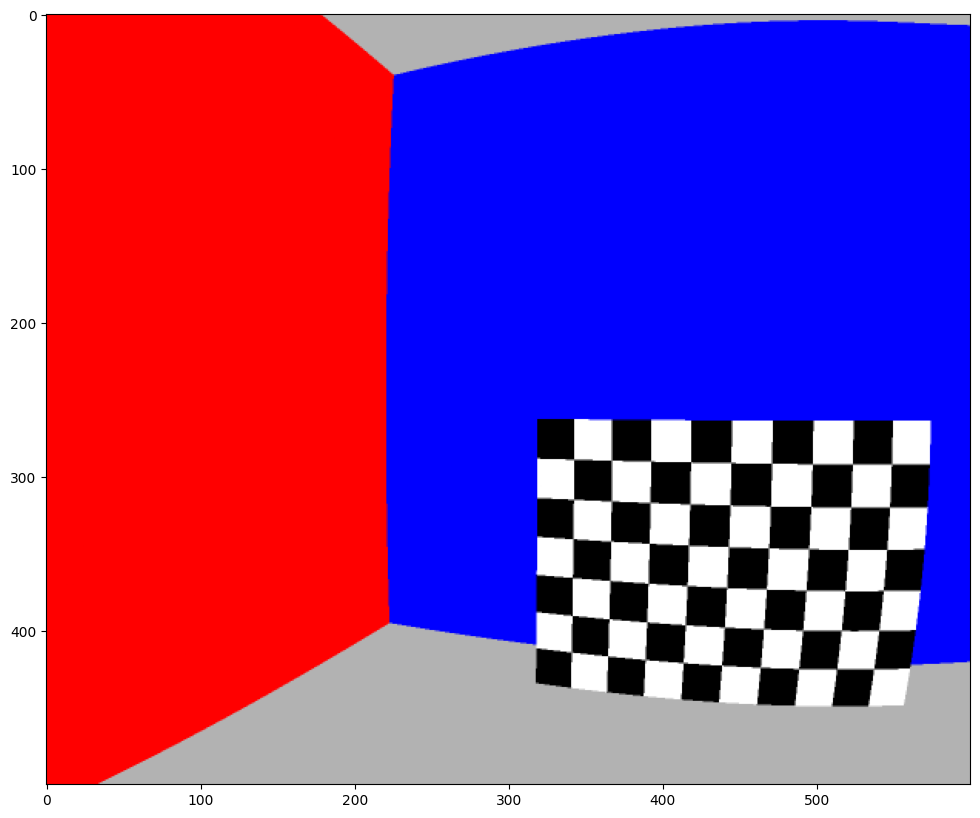

In [276]:
from pycamcal.primitives.pose import Pose3D
from pycamcal.simulation.raycasting import simulate_capture

camera_pose = Pose3D(
    np.array([0, -3.0, 2.0]),
    R3D.from_euler("xz", [-90, 20], degrees=True)
)

image = simulate_capture(scene, camera, camera_pose, rays_per_pixel=4)
print(image.shape)

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(image)

In [277]:
# from pycamcal.calibration.target_detection.target_detection import detect_checkerboard_target
# from pycamcal.calibration.target_detection.viz_utils import plot_target_detection

# target_points = detect_checkerboard_target(image, nrows=7, ncols=10)
# print(target_points)

# fig, ax = plt.subplots(figsize=(9, 7))
# plot_target_detection(image, target_points, ax=ax)